# 2022-08-24 Finite Differences

## Last time
* General shape of PDE solvers and stakeholders
* Comparing/plotting cost and accuracy
* Learning strategy

## Today
* Discussion and scoping
* Evaluating derivatives
* Taylor series and truncation error
* Stability

# Choices in scoping the class

## Theory

Analysis first, confirm using numerics.
Limited to simpler models.

## Applied
Numerics first, pointers to useful theory.

---

## Build from scratch

Limited to simpler models, but you'll understand everything under the hood.

## Build using libraries

More installation and software layers, but can solve more interesting problems.

# Consider the boundary value problem: find $u$:

\begin{gather} -\frac{d^2 u}{dx^2} = f(x) \quad x \in \Omega = (-1,1) \\
u(-1) = a \quad \frac{du}{dx}(1) = b .
\end{gather}

We say
* $f(x)$ is the "forcing"
* the left boundary condition is Dirichlet
* the right boundary condition is Neumann

We need to choose
* how to represent $u(x)$, including evaluating it on the boundary,
* how to compute derivatives of $u$,
* in what sense to ask for the differential equation to be satisfied,
* where to evaluate $f(x)$ or integrals thereof,
* how to enforce boundary conditions.

# Finite Difference/collocation approach to solve $u$:

\begin{gather} -\frac{d^2 u}{dx^2} = f(x) \quad x \in \Omega = (-1,1) \\
u(-1) = a \quad \frac{du}{dx}(1) = b .
\end{gather}

* Represent the function $u(x)$ by its values $u_i = u(x_i)$ at a discrete set of points $$ -1 = x_1 < x_2 < \dotsb < x_n = 1 . $$
  * The FD framework does not uniquely specify the solution values at other points
* Compute derivatives at $x_i$ via differencing formulas involving a finite number of neighbor points (independent of the total number of points $n$).
* FD methods ask for the differential equation to be satisfied pointwise at each $x_i$ in the interior of the domain.
* Evaluate the forcing term $f$ pointwise at $x_i$.
* Approximate derivatives at discrete boundary points ($x_n = 1$ above), typically using one-sided differencing formulas.

# Computing a derivative

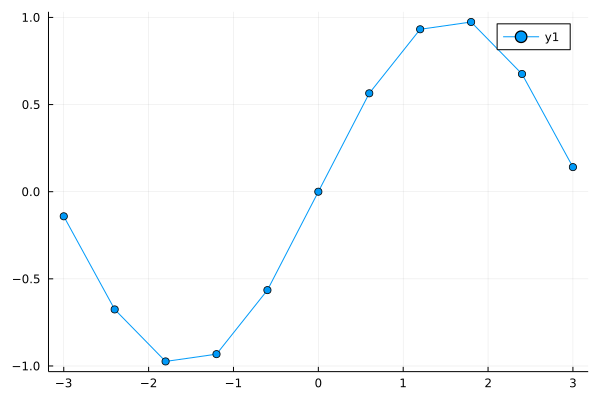

In [1]:
using Plots

n = 11
h = 6 / (n - 1)
x = LinRange(-3, 3, n)
u = sin.(x)

plot(x, u, marker=:circle)

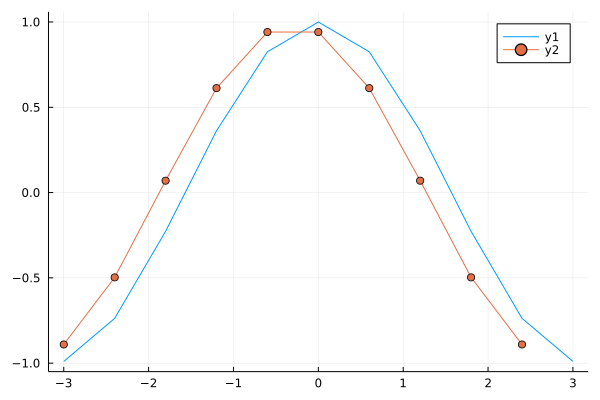

In [2]:
u_x = cos.(x)
fd_u_x = (u[2:end] - u[1:end-1]) / h

plot(x, u_x)
plot!(x[1:end-1], fd_u_x, marker=:circle)

# How accurate is it?

Without loss of generality, we'll approximate $u'(x_i = 0)$, taking $h = x_{i+1} - x_i$.

$$ u(x) = u(0) + u'(0)x + u''(0)x^2/2! + O(x^3)$$
and substitute into the differencing formula
$$ \begin{split} u'(0) \approx \frac{u(h) - u(0)}{h} = h^{-1} \Big( u(0) + u'(0) h + u''(0)h^2/2 + O(h^3) - u(0) \Big) \\
= u'(0) + u''(0)h/2 + O(h^2) . \end{split}$$
Evidently the error in this approximation is $u''(0)h/2 + O(h^2)$. We say this method is *first order accurate*.

# Activity on stability and accuracy computing derivatives

# A note on stable computation

In [3]:
x = 1e-15
@show x
@show log(1 + x)

x = 1.0e-15
log(1 + x) = 1.110223024625156e-15


1.110223024625156e-15

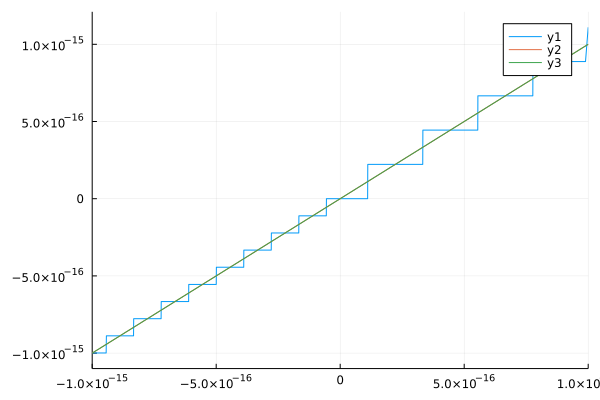

In [4]:
plot([x -> log(1 + x), log1p], xlims=(-1e-15, 1e-15))
plot!(x -> x)

# A few methods on grids

In [5]:
diff1l(x, u) = x[2:end],   (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1r(x, u) = x[1:end-1], (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1c(x, u) = x[2:end-1], (u[3:end] - u[1:end-2]) ./ (x[3:end] - x[1:end-2])
difflist = [diff1l, diff1r, diff1c]

n = 20
h = 2 / (n - 1)
x = LinRange(-3, 3, n)
u = sin.(x)
fig = plot(cos, xlims=(-3, 3))
for d in difflist
    xx, yy = d(x, u)
    plot!(fig, xx, yy, marker=:circle, label=d)
end

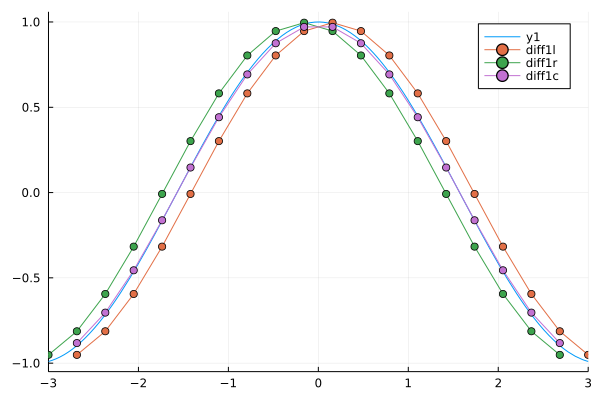

In [6]:
fig

# Measuring error on grids

In [7]:
using LinearAlgebra

grids = 2 .^ (2:10)
hs = 1 ./ grids
function refinement_error(f, fprime, d)
    error = []
    for n in grids
        x = LinRange(-3, 3, n)
        xx, yy = d(x, f.(x))
        push!(error, norm(yy - fprime.(xx), Inf))
    end
    error
end

refinement_error (generic function with 1 method)

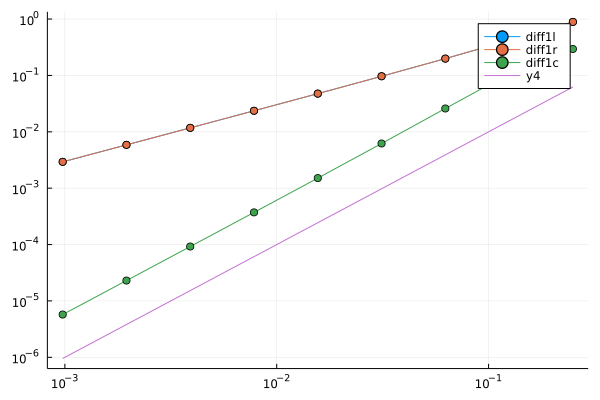

In [8]:
fig = plot(xscale=:log10, yscale=:log10)
for d in difflist
    error = refinement_error(sin, cos, d)
    plot!(fig, hs, error, marker=:circle, label=d)
end
plot!(fig, hs, hs .^ 2)

# Stability

Are there "rough" functions for which these formulas estimate $u'(x_i) = 0$?

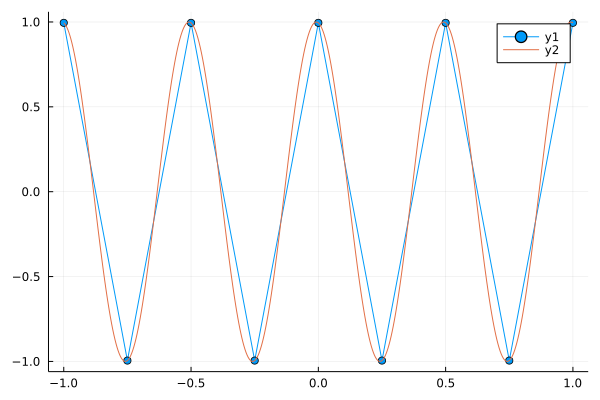

In [9]:
x = LinRange(-1, 1, 9)
f_rough(x) = cos(.1 + 4π*x)
fp_rough(x) = -4π*sin(.1 + 4π*x)

plot(x, f_rough, marker=:circle)
plot!(f_rough)

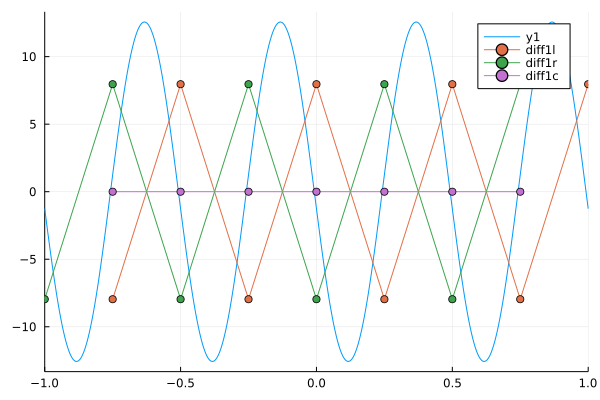

In [10]:
fig = plot(fp_rough, xlims=(-1, 1))
for d in difflist
    xx, yy = d(x, f_rough.(x))
    plot!(fig, xx, yy, label=d, marker=:circle)
end
fig

If we have a solution $u(x)$, then $u(x) + f_{\text{rough}}(x)$ is indistinguishable to our FD method.